# <center> CSCI 6515 - Project</center>
# <center>AKSHAY REDDY POTURI - B00822804</center>
# <center>LAKSHMI MANJARI ALAPATI - B00825788</center>

In [1]:
#importing all the required libraries

import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
import re
import nltk
import xml.etree.ElementTree as et
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from keras.models import Sequential,Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Concatenate, Embedding, Dropout, Flatten
import warnings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import zipfile
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.


# Step 1
## Load dataframe

<div style="font-size:18px"> <br>
* In this step, we are extracting all the .xml files from the given zip file and loading them into dataframe "df" with columns 'Headline','Text','bip:topics','dc.date.published','itemid','XMLfilename'.
    <br><br>
* We have concatenated the "Headline" and "Text" columns to create new column called "<b>Data</b>" on which we perform clustering and classification further.
</div>

In [2]:
#function to extract all the input zip files and place in a floder "Files"

def FilesExtraction():
    for filename in os.listdir('./Data'):
        if (filename.endswith(".zip")):
            with zipfile.ZipFile('./Data/'+filename, 'r') as reference:
                reference.extractall('./Files/')

#calling the function to extract input zip files

FilesExtraction()

In [2]:
# loading the dataframe with content extracted from xml files

def load_dataframe():
    df = pd.DataFrame(columns=['Headline','Text','bip:topics','dc.date.published','itemid','XMLfilename'])

    rootdir = './Files/'
    for file in os.listdir(rootdir):
        fileName = file
        if(file.endswith(".xml")):
            file = open(os.path.join('./Files/', file)).read()        
            file_contents = BeautifulSoup(file)
            headline = file_contents.headline.text
            text = file_contents.findAll("text")[0].text
            itemId = file_contents.newsitem["itemid"]        
            dc_date_published = file_contents.findAll(attrs={"element" : "dc.date.published"})[0]['value']
            bip_topics = file_contents.findAll(attrs={"class" : "bip:topics:1.0"})
            if(len(bip_topics) > 0):        
                bip_topics = bip_topics[0].findAll("code")                  
                code = bip_topics[0]['code']
                df = df.append({'Headline': headline, 
                                   'Text': text, 
                                   'bip:topics': code,
                                   'dc.date.published': dc_date_published, 
                                   'itemid': itemId,
                                   'XMLfilename': fileName
                                  }, ignore_index=True)
            else:
                 df = df.append({'Headline': headline, 
                                   'Text': text, 
                                   'bip:topics': "",
                                   'dc.date.published': dc_date_published, 
                                   'itemid': itemId,
                                   'XMLfilename': fileName
                                  }, ignore_index=True)
    return df

In [3]:
# loading the dataframe
df = load_dataframe()
df.shape

(48375, 6)

In [4]:
#Joining the headline and text columns

df['Data'] = df['Headline'].str.cat(df['Text'], sep =" ")
df.shape

(48375, 7)

# Step 2
# Pre-processing: 

<div style="font-size:16px"> <br>
Removing null values, special characters, stop words, non-noun tokens, stemming and lemmatization
    </div>

# Clustering - KMeans:

<div style="font-size:16px"> <br>
Before beginning with clustering, features were extracted from the documents using term frequency - inverse document frequency(tf- idf) technique and topic modelling is done using the Latent Dirichlet Allocation(LDA) method to reduce the dimensionality in documents which improved the clustering performance. 
    </div>

#### Reason for choosing KMeans: 
<div style="font-size:16px"> <br>
Among all the available clustering techniques, we have chosen KMeans clustering method for creating the document clusters. Kmeans is one of the soft clustering techniques in which each document is assigned to only one cluster and unlike DB SCAN algorithm, KMeans will not be affected much by any small changes in the tokens of documents. Also, performance of KMeans is better when compared to other techniques. Therefore, we have chosen KMeans to perform clustering.
    </div>

#### K Value - Elbow: 
<div style="font-size:16px"> <br>
To determine the value of K, we have used Elbow method in which the Silhouette score will be calculated for various number of clusters in the given range and a graph will be created with Silhouette scores on y-axis and number of clusters on x-axis. The best value for K is chosen at the point where an elbow formed in the graph indicating the significance improvement in the clusters is found for that specific k value.
</div>

<div style="font-size:16px"> <br>
Once the KMeans clustering is completed, we have assigned the cluster ids to the corresponding documents in a new column called "cluster_id" of the dataframe "df".
</div>


# Classification on clusters:

<div style="font-size:16px"> <br>
To perform classification on each individual cluster, we have choosen Decision Tree Classifier and evaluated the performance using both the train-test-split method and cross-validation approach with 5 folds. The accuracy scores on training and testing datasets can be seen at the end of this section.
</div>

In [5]:
#function to preprocess the text column of dataframe df

def text_preprocessing(param_df):
    
    # removing rows containing null values
    param_df = param_df.dropna()

    # remove special characters and numbers
    param_df.Data = param_df.Data.apply(lambda x: re.sub(r'[^a-z]', ' ', x.lower()))    
    
    # remove all tokens except nouns
    accepted_tags={'NN','NNS','NNP','NNPS'}
    param_df.Data = param_df.Data.apply(lambda x: " ".join([pair[0] for pair in nltk.pos_tag(word_tokenize(x)) if pair[1] in accepted_tags]))    
    
    # remove stop words and lemmetization
    stopwords_list = set(stopwords.words("english"))    
    lem = WordNetLemmatizer()
    param_df.Data = param_df.Data.apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split() if word not in stopwords_list]))       
    
    # stemming
    porter = PorterStemmer()
    param_df.Data = param_df.Data.apply(lambda x: " ".join([porter.stem(word) for word in x.split()]))
     
    return param_df

In [6]:
#calling the pre-processing function
df = text_preprocessing(df)

In [7]:
# sample structure of dataframe
df.head()

,Headline,Text,bip:topics,dc.date.published,itemid,XMLfilename,Data
0,RTRS-NAB jumps 2.3 pct on buy-back plan.,\nShares in National Australia Bank Ltd jumped...,C15,1997-03-24,464661,464661newsML.xml,rtr nab jump plan share australia bank ltd cen...
1,Care Group Inc Q4 shr loss vs profit.,\n(000's Omitted)\n\t\t\t\t\t YEAR END DECEM...,C15,1997-03-31,476242,476242newsML.xml,care group loss v profit year end decemb reven...
2,France urges Israel to stick by Oslo accords.,\nFrance urged Israel on Monday to stick to th...,GCAT,1997-03-24,464382,464382newsML.xml,franc urg accord franc israel monday peac acco...
3,Former Mexican official denies taking drug bri...,\nA former Mexican deputy attorney general on ...,GCAT,1997-03-15,445205,445205newsML.xml,offici deni drug deputi attorney gener friday ...
4,Krupp says Dortmund furnace won't be closed.,\nKrupp will not close at least part of its Do...,C18,1997-03-20,457626,457626newsML.xml,krupp dortmund furnac krupp part dortmund stee...


In [8]:
# sample preprocessed text from first row of dataframe
df.Data[0]

'rtr nab jump plan share australia bank ltd cent percent monday afternoon trade plan percent share cent percent day cent trade share price stock exchang figur share share buyback analyst broker market prospect buy prospect buyback year novemb result share number share dividend reinvest bonu share share novemb share time issu exchang tier capit nab issu capit unit month demand nab detail buy issu buy share dividend reinvest plan share share issu group capit posit flexibl issu gener capit reserv group valu sharehold implement buy program nab director argu statement group develop capit manag buy april end octob share whichev sydney newsroom'

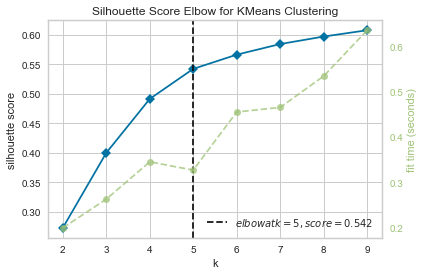

Total number of clusters formed:  5 

Cluster- 0 :  10759  samples
Cluster- 1 :  13349  samples
Cluster- 2 :  8676  samples
Cluster- 3 :  6115  samples
Cluster- 4 :  9476  samples

Cluster- 0 :
Training score:  0.9961492497676271
Testing score:  0.7205700123915737


/Users/akshayreddypoturi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Cross validation score:  0.7194575254142823

Cluster- 1 :
Training score:  0.993257705479452
Testing score:  0.4651685393258427


/Users/akshayreddypoturi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Cross validation score:  0.44017421082642905

Cluster- 2 :
Training score:  0.9944014490367199
Testing score:  0.7026507875528236


/Users/akshayreddypoturi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Cross validation score:  0.7143875932208166

Cluster- 3 :
Training score:  0.9922897196261682
Testing score:  0.8005449591280654


/Users/akshayreddypoturi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Cross validation score:  0.7970802457764679

Cluster- 4 :
Training score:  0.9942710688979346
Testing score:  0.7534294759057334


/Users/akshayreddypoturi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Cross validation score:  0.7319868410503625


In [37]:
# function for finding the k value for k means clustering using elbow method
def find_num_of_clusters(features):

    visualizer = KElbowVisualizer(KMeans(), metric='silhouette', k=(2,10))
    visualizer.fit(features)        # Fit the data to the visualizer
    visualizer.show() 
    
    return visualizer.elbow_value_

# function for doing the clustering and assignning cluster id for every document in dataframe
def get_clusters():
    
    vectorizer = TfidfVectorizer(min_df = 3)
    tfidf_data = vectorizer.fit_transform(df.Data)

    lda = LatentDirichletAllocation(n_components=10, random_state=0)
    lda_feature_matrix = lda.fit_transform(tfidf_data)
    features = pd.DataFrame(lda_feature_matrix)
    
    num_clusters=find_num_of_clusters(features)
    
    # K-means clustering
    km = KMeans(n_clusters=num_clusters)
    km.fit(features)
    clusters = km.labels_.tolist()
    new_df = df.copy()
    new_df['cluster_id'] = clusters
    return new_df, num_clusters, km, features

# function for applying decision tree classifier on every cluster and evaluating the clusters
def generate_classifier(new_df, num_clusters):
    cluster_dfs = []
    dt_scores = {}
    for i in range(0, num_clusters):
        print("\nCluster-", i , ':')
        cluster_df = new_df.loc[new_df['cluster_id'] == i]
        
        # tfidf
        vectorizer = TfidfVectorizer()
        X_train_counts = vectorizer.fit_transform(cluster_df.Data)         
        cluster_features_df = pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names())
        
        # train-test-split
        X_train, X_test, y_train, y_test = train_test_split(cluster_features_df, cluster_df['bip:topics'], test_size=0.30, random_state=42)
        
        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X_train, y_train)
        testing_score = clf.score(X_test,y_test)
        dt_scores[i] = testing_score
        
        print("Training score: ", clf.score(X_train,y_train))   
        print("Testing score: ", testing_score)
        
        # cross validation using 5 folds
        all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
        print("Cross validation score: ", all_accuracies.mean())

        cluster_dfs.append(cluster_df)
    return cluster_dfs, dt_scores

#calling the functions for finding k value for clusters, performing clustering and creating the decision tree 
#classifier on the clusters
result = get_clusters()
new_df = result[0]
num_clusters = result[1]
km=result[2]
features=result[3]

dict_clustercounts = new_df['cluster_id'].value_counts()\
cluster_dict = sorted((dict_clustercounts.to_dict(OrderedDict)).items())
print("Total number of clusters formed: ",num_clusters, '\n')
for item in cluster_dict:
    print("Cluster-", str(item[0]), ': ', str(item[1]), ' samples')

output = generate_classifier(new_df, num_clusters)
cluster_dfs = output[0]
dt_scores = output[1]

# Step 3
# Evaluating quality of clusters and plotting all the clusters in 2d space using TSNE:

<div style="font-size:16px"> <br>
There are many evaluation metrics available to evaluate the quality of clusters. Few of them are "Adjusted Rand index","Homogeneity","Completeness", "V-measure",and "Mutual Information based scores" which needs classes to be passed to evaluate the clusters. Since we have a total of 102 bip topics, the evaluation of clusters aganist the bip topics class needs larger number of clusters to be performed to provide a good score. Therefore, we have chosen Silhouette score which does not need classes information to evaluate the quality of clusters and evaluates the density of clusters based on the data points themselves. 
    </div>

#### Silhouette score: 
<div style="font-size:16px"> <br>
We have chosen Silhouette score as the evaluation metric for the clusters created by the KMeans algorithm. Silhouette score for a data point is calculated based on the difference of average distance to all other points in the same cluster and average distance to all other data points of the nearest neighbouring cluster. Silhouette score for an entire cluster is simply mean of Silhouette scores of all data points in that cluster. It ranges between -1 and 1, and higher the Silhouette score indicates that all the data points in any given cluster are close to each other when compared to distance from data points in other clusters.
</div>


#### We have used TSNE to reduce the dimensions to 2 dimensional space and plot the documents from all clusters. This is useful in visualizing and understanding how good the clusters are formed for all the given input documents. 


Homogeneity: 0.199
Completeness: 0.359
V-measure: 0.256
Adjusted Rand-Index: 0.193
Silhouette Coefficient:  0.5425292800617102


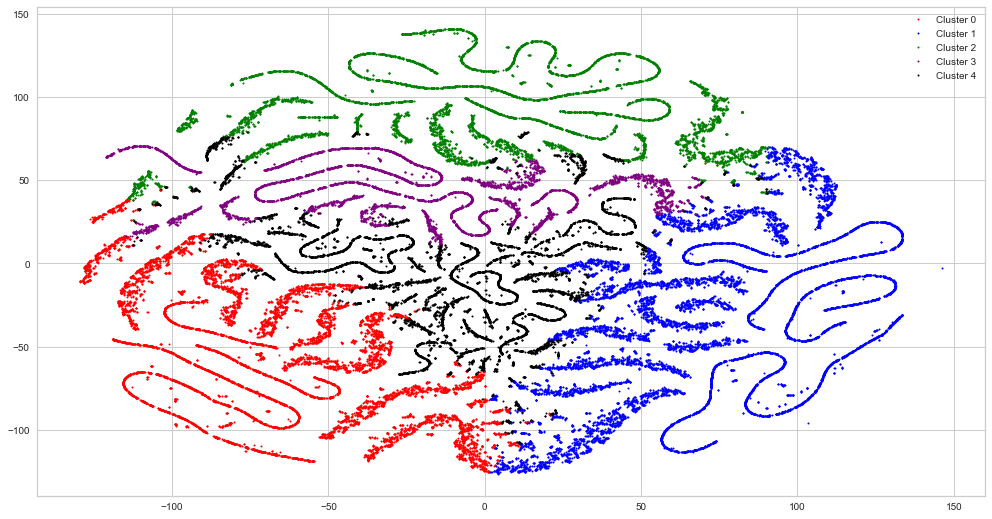

In [38]:
# function to evaluate cluster quality and plot using TSNE

def evaluate_cluster_quality():
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(new_df["bip:topics"], km.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(new_df["bip:topics"], km.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(new_df["bip:topics"], km.labels_))
    print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(new_df["bip:topics"], km.labels_))
    print("Silhouette Coefficient: ",metrics.silhouette_score(features, km.labels_,
                                      metric='euclidean'))

    tsne_model = TSNE(n_components=2, random_state=1, init='pca', perplexity=30.0,
                      early_exaggeration=4.0, learning_rate=1000)
    data_points = tsne_model.fit_transform(features)
    x_point, y_point = data_points[:, 0], data_points[:, 1]

    %matplotlib inline 
    cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4:'black', 5:'yellow', 6:'brown', 7:'violet',
                     8: 'pink',9:'orange'}

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=x_point, y=y_point, cluster=new_df.cluster_id, data=new_df.Data)) 

    #group by cluster
    groups = cluster_df.groupby('cluster')

    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) 

    for name, group in groups:
        col_name=cluster_colors[name]
        if(col_name=='red'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 0') 
        if(col_name=='blue'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 1') 
        if(col_name=='green'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 2') 
        if(col_name=='purple'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 3') 
        if(col_name=='black'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 4') 
        if(col_name=='yellow'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 5') 
        if(col_name=='brown'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 6') 
        if(col_name=='violet'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 7') 
        if(col_name=='pink'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 8') 
        if(col_name=='orange'):
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=2,  color=cluster_colors[name], 
               label = 'Cluster 9') 
    ax.legend(numpoints=1)  
    plt.show() 
    
evaluate_cluster_quality()

## Step 4

<div style="font-size:18px"> <br>
    For Step4 and Step5 to perform feature extraction and classification, we followed first research paper[1] in the given project("Text feature extraction based on deep learning: a review.") in which multiple techniques are discussed. Among these techniques, we decided to implement the feature extraction using CNN and Autoencoders using Glove word embeddings and TF-IDF respectively. Once these two approaches are implemented, we are comparing the performances of both the techniques on each cluster with that of decision tree classifier as the last step of this project. Below sections provide further details and implementations of the two techniques. 
 </div>

### Approach 1 - Feature extraction using CNN neural networks
* As explained in the first paper, since CNN is one of the most followed approaches for feature extraction, we made use of convolutional layers which uses filter matrix to transform previous layer into vectors of smaller size. These convolutional layers are followed by max pooling layers which uses given filter size to convert the vectors in convolutional layer by choosing maximum value of filter. This way by the end of the last max pooling layer, we will get convolved features of original feature matrix. These features are used for modelling in later stage using a Sequential model. 

* Therefore, as part of this approach, we have built CNN with 6 convolutional layers of 5 different filter sizes, each layer followed by a max pooling layer of a specific filter size. 

* Since we have one-hot encoding vectors or Tf-Idf vectors are thousands in number, we decided to explore Glove pre-trained embeddings which packs the dimensions into much fewer dimensions. Glove embeddings are the low-dimensional dense vectors which are learned from the data. Here, in our project, we have vectorized the data and used 100 dimensional Embedding file to deal with our vocabulary set. Using these embeddings, we have built an embedding matrix of shape (max_words, 100) where each entry "x" contains the 100-dimensional vector for the word of index "x" in the word index list that is built during tokenization. Also, we have restricted the data to its first 1000 tokens so that the model will be learning to classify the documents after looking at just 1000 tokens of the document.

* We have loaded these glove embeddings into the model as an embedding layer of CNN in which embedding matrix constructed above is used as fixed weights of the embedding layer. This means that since these are pre-trained embeddings, we need not update the learned word weights in this model during training phase. Therefore we have set the trainable attribute for the model as False.

* We have extracted new features for both X_train and X_test sets using the built CNN model and used it in further step

### Approach 2 - Feature extraction using Autoencoder

* Since the previous approach uses pre trained word embeddings, we wanted to explore an approach without using word embeddings. For this, we decided to convert the "data" column of clusters to Tf-Idf vectors and extract features relavant to the modelling purpose. As another approach explained in the paper, we decided to use feature extraction using Autoencoders of deep neural networks.

* Autoencoder usually contains input layer, output layer and a hidden layer. While the hidden layer contains less number of compact features, input layer takes all the features and tries to reconstruct the features with reduced features obtained in hidden layer. It iterates through the layers in each epoch like normal model but the only difference is it adjust weights so that it tries to reconstruct the same input into output layer on each iteration. This way, after all epochs, we will obtain less possible features using which we can perform classification in later stages. Here, in our project, we have used stacked autencoder which means instead of one hidden layer, we have given 7 hidden layers.


### Approach 1 - Feature extraction - CNN with word embeddings(Glove)

In [39]:
# function for creating the embedding matrix using the 100 dimensional glove embeddings
def get_embedding_matrix(word_index):
    # create token-embedding mapping
    embeddings_index = {}
    for i, line in enumerate(open('glove.6B.100d.txt', encoding="utf8")):
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

    embedding_matrix = np.zeros((len(word_index) + 1, 100))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# function for creating the vectors for all tokens in the dataframe
def getWordVectors(X_train, X_test):
    # concatenating X_train and y_train into whole text
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    
    # create a tokenizer 
    token = Tokenizer(num_words=75000)
    token.fit_on_texts(text)
    word_index = token.word_index
    
    # pad sequences
    text = pad_sequences(token.texts_to_sequences(text), maxlen=1000)

    # arranging text into rows by keeping into indices
    indices = np.arange(text.shape[0])
    text = text[indices]
    
    # splitting text again to X_train and X_test
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    
    return X_train, X_test, word_index

# function for creating the CNN model with layers
def build_cnn(embedding_matrix, word_index):
    # setting variables
    max_len = 1000
    filter_sizes = [2,3,4,5,6]
    node_val = 128
    convs = []
    embedding_dim = 100
    dropout_val = 0.25
    
    # build CNN
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len,
                          trainable=False)

    sequence_input = Input(shape=(max_len,), dtype='int32')

    embedded_sequences = embedding_layer(sequence_input)

    for val in filter_sizes:
        l_conv = Conv1D(node_val, kernel_size=val, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    layer_concat = Concatenate(axis=1)(convs)
    layer_cov1 = Conv1D(node_val, 5, activation='relu')(layer_concat)
    layer_pool1 = MaxPooling1D(30)(layer_cov1)
    
    model = Model(sequence_input, layer_pool1)
    return model   

# function in which the input data is feeded to CNN model and extracting the features
def cnn_extract_features(cluster_df):
    # converting target column to labels
    target = cluster_df["bip:topics"]
    classes = target.unique().tolist()
    target = cluster_df['bip:topics'].apply(classes.index)
    
    # train-test-split
    X_train, X_test, y_train, y_test = train_test_split(cluster_df['Data'], target, test_size=0.30, random_state=42)
    
    # get word vectors 
    result = getWordVectors(X_train, X_test)
    X_train = result[0]
    X_test = result[1]
    word_index = result[2]
    
    embedding_matrix = get_embedding_matrix(word_index)
    
    # get CNN model to extract features
    model = build_cnn(embedding_matrix, word_index)
    
    # extracting features
    X_train_features = model.predict(X_train)
    X_test_features = model.predict(X_test)

    return X_train_features, X_test_features, y_train, y_test

### Approach 2 - Feature extraction - Autoencoder with Tf-idf

In [40]:
def get_autoencoder_features(X):
    input_i = Input(shape=(X.shape[1],))
    encoded_h1 = Dense(4000, activation='tanh')(input_i)
    encoded_h2 = Dense(3000, activation='tanh')(encoded_h1)
    encoded_h3 = Dense(2000, activation='tanh')(encoded_h2)
    latent = Dense(1000, activation='tanh')(encoded_h3)
    decoder_h1 = Dense(2000, activation='tanh')(latent)
    decoder_h2 = Dense(3000, activation='tanh')(decoder_h1)
    decoder_h3 = Dense(4000, activation='tanh')(decoder_h2)
    output = Dense(X.shape[1], activation='sigmoid')(decoder_h3) # Dense 4

    encoder = Model(input_i, latent) # model for only encoder
    autoencoder = Model(input_i, output)
    autoencoder.compile('sgd','mse')
        
    autoencoder.fit(X,X,epochs=10,batch_size=256,verbose=0, validation_split=0.2)
    X_new = encoder.predict(X)  
    return X_new

# Step 5
## Fitting deep neural network model using extracted features

#### Changes compared to Assignment 1:
* In the Assignment 1, we have performed the classification on entire dataset whereas, in this project, we have divided the data into best possible clusters and performed classification on each individual cluster
* The classifiers used in the assigment were normal machine learning classifiers whereas here, Initially we performed classification on individual clusters using the decision trees with tf-idf vecors later we have extracted features using deep neural networks and applied deep neural networks classifiers and then compared the performances with machine learning models used before feature extraction.
* The features were not reduced in assignment 1 and hence model training times were high making it computationally expensive. Whereas in our project, we are reducing the features with the help of Deep Neural Networks, and classifying the documents using the extracted features. We have done feature extraction using various models like CNN and autoencoders and compared the performances.

#### Reason for changes:
* Training models on whole dataset with thousands of features makes it computationally worse and less flexibile to perform hyper parameter tuning. Therefore, it is important to reduce features using any dimensionality reduction technique
* To perform feature extraction, although there are many traditional pattern recognition methods, deep learning learns the features automatically instead of adopting hand crafted features. Also, deep learning models quickly train themselves by acquiring effective feature representation of training data. 
* Therefore, to effectively utilize the benefits of deep learning models, we considered to use them for feature extraction and to perform our classification task.

### Approach 1 - Calling all the functions related to CNN feature extraction and creating sequential models for all clusters

In [43]:
# function for fitting the sequential model using the extracted features in previous step and evaluating the 
# model performance

def model_new_features(X_train_features, X_test_features, y_train, y_test, n_classes):
    dropout_val = 0.25
    # build model
    model_transfer = Sequential()
    model_transfer.add(Flatten(input_shape=X_train_features.shape[1:]))
    model_transfer.add(Dense(512, activation='relu'))
    model_transfer.add(Dense(n_classes, activation='softmax'))
    
    # run cnn
    model_transfer.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model_transfer.fit(X_train_features, y_train,
                       epochs=50, 
                       verbose=0,
                       validation_split=0.2, 
                       batch_size=256)
    
    # Testing set evaluation
    predicted = model_transfer.predict(X_test_features)
    predicted = np.argmax(predicted, axis=1)
    score = metrics.accuracy_score(y_test,predicted)
    print("Testing score:" , score)
    
    # Training set evaluation
    predicted = model_transfer.predict(X_train_features)
    predicted = np.argmax(predicted, axis=1)
    print("Training score:", metrics.accuracy_score(y_train,predicted))
    return score

# for each cluster, extract features and use extracted features on CNN classifier

dict_scores_cnn={}

for cluster_df in cluster_dfs:
    X_train_features, X_test_features, y_train, y_test = cnn_extract_features(cluster_df)
    n_classes = len(cluster_df['bip:topics'].unique())
    cluster_id = ''
    for item in cluster_dict:
        if(item[1] == cluster_df.shape[0]):
            cluster_id = item[0]
    
    print("\nCluster-", cluster_id)
    print('****************************************************')
    score = model_new_features(X_train_features, X_test_features, y_train, y_test, n_classes)
    dict_scores_cnn[cluster_id] = score


Cluster- 0
****************************************************
Testing score: 0.7385377942998761
Training score: 0.9086442703492232

Cluster- 1
****************************************************
Testing score: 0.4811485642946317
Training score: 0.7174657534246576

Cluster- 2
****************************************************
Testing score: 0.7387629658086823
Training score: 0.9010373785608431

Cluster- 3
****************************************************
Testing score: 0.8212534059945504
Training score: 0.9345794392523364

Cluster- 4
****************************************************
Testing score: 0.7724234963067182
Training score: 0.9378863259460274


### Approach 2 - Calling all the functions related to Autoencoder feature extraction and creating sequential models for all clusters

In [48]:
from keras.layers import Input, Dense
from keras.models import Model

num_clusters = len(cluster_dict)
dict_scores_auto = {}

for i in range(0, num_clusters):
    print("\nCluster-", i , ':')
    cluster_df = new_df.loc[new_df['cluster_id'] == i]
        
    # tfidf
    vectorizer = TfidfVectorizer()
    X_train_counts = vectorizer.fit_transform(cluster_df.Data)         
    cluster_features_df = pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names())
        
    X=cluster_features_df
    Y=cluster_df['bip:topics']
        
    X_new = get_autoencoder_features(X)
        
    n_classes = len(cluster_df['bip:topics'].unique())
    target = cluster_df["bip:topics"]
    classes = target.unique().tolist()
    target = cluster_df['bip:topics'].apply(classes.index)
        
    # train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X_new, target, test_size=0.30, random_state=42)
        
    dropout_val = 0.25
    # build model
    model_transfer = Sequential()
    model_transfer.add(Dense(512, input_shape=X_train.shape[1:],activation='relu'))
    model_transfer.add(Dense(n_classes, activation='softmax'))

    model_transfer.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    model_transfer.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2, batch_size=256)

    # Testing set evaluation
    predicted = model_transfer.predict(X_test)
    predicted = np.argmax(predicted, axis=1)
    score = metrics.accuracy_score(y_test,predicted)
    dict_scores_auto[i] = score
    print("Testing score:" , score)

    # Training set evaluation
    predicted = model_transfer.predict(X_train)
    predicted = np.argmax(predicted, axis=1)
    print("Training score:", metrics.accuracy_score(y_train,predicted))    


Cluster- 0 :
Testing score: 0.7763320941759604
Training score: 0.8750497941840393

Cluster- 1 :
Testing score: 0.5305867665418227
Training score: 0.7165025684931506

Cluster- 2 :
Testing score: 0.7913945447560508
Training score: 0.902519347933476

Cluster- 3 :
Testing score: 0.8403269754768392
Training score: 0.9380841121495327

Cluster- 4 :
Testing score: 0.7847344354555047
Training score: 0.9054726368159204


# Comparing the performance of models for all clusters before and after feature extraction done using CNN and Autoencoders

* As one of the most used feature extraction techniques mentioned in first research paper[1], we decided to explore Autoencoder and CNN deep learning approaches and compare the performances on each cluster to understand them better. 
* So, we have plotted the below bar graph to show the accuracies for all clusters before feature extraction using the decision trees classifier and after feature extraction using the deep neural networks techniques, CNN and Auto encoders. 
* As it can be observed that the decision tree classifier performed comparitively low and feature extraction certainly helped in improving the accuracies on each and every cluster. 

* Although both CNN and Autoencoder feature extraction techniques performed similarly on cluster 3 and cluster 4, Autoencoder performed significantly better on cluster 0, cluster 1 and cluster 2.

* To summarize, the approach of conversion of text to Tf-Idf vectors and extraction the features using Autoencoders followed by applying sequential neural network model is outperforming the other techniques on our dataset.

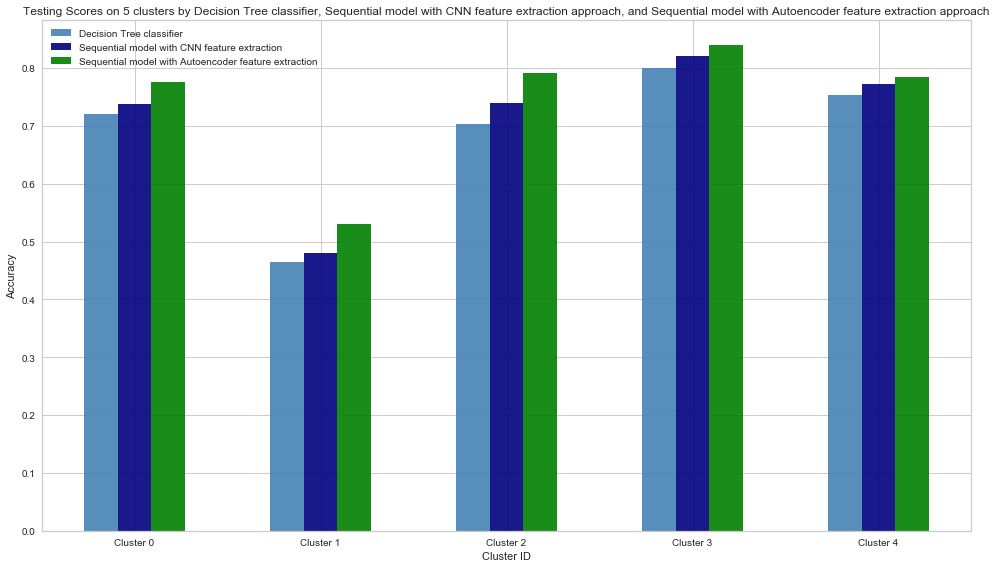

In [50]:
# data to plot
import matplotlib.pyplot as plt
n_groups = 5
dt_scores = (dt_scores[0], dt_scores[1], dt_scores[2], dt_scores[3], dt_scores[4])
cnn_scores = (dict_scores_cnn[0], dict_scores_cnn[1], dict_scores_cnn[2], dict_scores_cnn[3], dict_scores_cnn[4])
auto_scores = (dict_scores_auto[0],dict_scores_auto[1], dict_scores_auto[2], dict_scores_auto[3], dict_scores_auto[4])

# create plot
fig, ax = plt.subplots(figsize=(15,8))
index = np.arange(n_groups)
bar_width = 0.18
opacity = 0.9

rects1 = plt.bar(index, dt_scores, bar_width,
alpha=opacity,
color='steelblue',
label='Decision Tree classifier')

rects2 = plt.bar(index + bar_width, cnn_scores, bar_width,
alpha=opacity,
color='navy',
label='Sequential model with CNN feature extraction')

rects3 = plt.bar(index + 2* bar_width, auto_scores, bar_width,
alpha=opacity,
color='green',
label='Sequential model with Autoencoder feature extraction')

plt.xlabel('Cluster ID')
plt.ylabel('Accuracy')
plt.title('Testing Scores on 5 clusters by Decision Tree classifier, Sequential model with CNN feature extraction approach, and Sequential model with Autoencoder feature extraction approach')
plt.xticks(index + bar_width, ('Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'))

plt.legend()
plt.tight_layout()
plt.show()

# References

[1] X. Sun1, Y. Sun, and Y. Gao1, “Text feature extraction based on deep learning: a review,” EURASIP Journal on Wireless Communications and Networking, 15-Dec-2017. [Online]. Available: https://jwcn-eurasipjournals.springeropen.com/articles/10.1186/s13638-017-0993-1. [Accessed: 10-Dec-2019].

[2] Blog.keras.io. (2019). Building Autoencoders in Keras. [online] Available at: https://blog.keras.io/building-autoencoders-in-keras.html [Accessed 10 Dec. 2019].

[3] Brownlee, J. (2019). How to Use Word Embedding Layers for Deep Learning with Keras. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/ [Accessed 10 Dec. 2019].

[4] Medium. (2019). Deep Learning Techniques for Text Classification. [online] Available at: https://medium.com/datadriveninvestor/deep-learning-techniques-for-text-classification-9392ca9492c7 [Accessed 10 Dec. 2019]. 

[5] Python, R. (2019). Practical Text Classification With Python and Keras – Real Python. [online] Realpython.com. Available at: https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn [Accessed 10 Dec. 2019].

[6] Scikit-learn.org. (2019). sklearn.decomposition.LatentDirichletAllocation — scikit-learn 0.22 documentation. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html [Accessed 10 Dec. 2019].